In [42]:
from heuristicas import *
from master import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [46]:
import pickle

with open("data.pkl", "rb") as f:
    data = pickle.load(f)

total_filmes = data["total_filmes"]
gulosa_tempos_execucao = data["gulosa_tempos_execucao"]
aleatoria_tempos_execucao = data["aleatoria_tempos_execucao"]
aleatoria_assistido = data["aleatoria_assistido"]
gulosa_assistido = data["gulosa_assistido"]
total_categorias = data["total_categorias"]
filmes_por_categoria = data["filmes_por_categoria"]
gulosa_tempo_tela = data["gulosa_tempo_tela"]
aleatoria_tempo_tela = data["aleatoria_tempo_tela"]

<div style="text-align: center;">
    <h1 style="font-size: 36px; color: #FFFFFF; font-weight: bold;">
        Comparação entre Heurísticas Gulosa e Aleatória<br>para Programação de Filmes
    </h1>
    <h2 style="font-size: 24px; color: #FFFFFF; font-weight: bold;">
        Autor: Beni Kracochansky
    </h2>
    <hr style="width: 50%; border: 1px solid #FFFFFF;">
</div>

## Implementação das Heurísticas

### Heurística Gulosa

A heurística gulosa seleciona os filmes com base no horário de término, de forma crescente, escolhendo os filmes que começam primeiro e não conflitam com os filmes já escolhidos, além de verificar se há vagas disponíveis na categoria do filme.

1. Tratamento do input:
    * O arquivo de input contém o número de filmes, as categorias e as informações de cada filme (hora de início, hora de fim e categoria).
    * O algoritmo lê o arquivo e armazena as informações em estruturas de dados adequadas.

2. Lógica do output:
    * O algoritmo ordena os filmes com base no horário de término, de forma crescente.
    * A heurística seleciona os filmes nessa ordem, garantindo que não haja conflitos de horário e que haja vagas disponíveis na categoria do filme.
    * O output contém a quantidade máxima de filmes que podem ser assistidos de acordo com as restrições de horários e número máximo por categoria.

3. Invariantes:
    * A lista de filmes é sempre ordenada com base no horário de término, de forma crescente.
    * Não há conflitos de horário entre os filmes selecionados.
    * O número máximo de filmes por categoria é respeitado.

```c++ 
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>
#include <random>
#include <ctime>

// Define the Movie structure with start, end, category, and index fields
struct Movie {
    int start, end, category, index;
};

// Function prototypes
bool compareMovies(const Movie &a, const Movie &b);
bool timeOverlap(int start1, int end1, int start2, int end2);
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory);

// Compare function for sorting movies by end time, and start time in case of a tie
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}


// Function to check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    if (!((start1 >= end2) || (end1 <= start2))) {
        return true;
    }
    else {
        return false;
    }
}


// Function to read movies from input file and return a vector of Movie structures
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory) {
    std::ifstream inputFile(filename);

    // Read the number of movies and categories from the input file
    inputFile >> N >> M;

    // Resize the maxMoviesPerCategory vector according to the number of categories
    maxMoviesPerCategory.resize(M);

    // Read the maximum number of movies per category
    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    // Initialize the movies vector with the number of movies
    std::vector<Movie> movies(N);

    // Read the movie information
    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        if (movies[i].end < movies[i].start) {
            movies[i].end += 24;
        }
        movies[i].index = i; // Set the index of the movie
    }

    // Close the input file
    inputFile.close();
    return movies;
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        std::cerr << "Usage: " << argv[0] << " <input_file>" << std::endl;
        return 1;
    }

    std::string input_file = argv[1];
    int N, M;
    std::vector<int> maxMoviesPerCategory;

    // Passe o nome do arquivo de input para a função readMovies
    std::vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);
    

    // Sort the movies by end time, and start time in case of a tie
    std::sort(movies.begin(), movies.end(), compareMovies);

    // Initialize the chosenMoviesPerCategory vector
    std::vector<int> chosenMoviesPerCategory(M, 0);
    std::vector<Movie> chosenMovies;
    int moviesWatched = 0;

    // Initialize a vector to track which movies have been selected
    std::vector<bool> movieSelected(N, false);

    // Initialize the random number generator
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_real_distribution<double> distribution(0.0, 1.0);
    gen.seed(rd() + time(0));

    // Start the timer
    auto startTime = std::chrono::steady_clock::now();

    // Iterate over the sorted movies
    for (const Movie &movie : movies) {

        double randomValue = distribution(gen);
        if (randomValue <= 0.25) {

            // Make another alearization to find an alternative movie
            std::uniform_int_distribution<int> distribution2(movie.index, N - 1);
            bool conflict2 = false;
                
            int randomValue2 = distribution2(gen);

            if (movies[randomValue2].start == movies[randomValue2].end) {
                continue;
            }

            for (auto& chosen_movie: chosenMovies){
                // verify if movies is valid to be selected compared to movie
                if (!(!(timeOverlap(movies[randomValue2].start, movies[randomValue2].end, chosen_movie.start, chosen_movie.end)) && (chosenMoviesPerCategory[movies[randomValue2].category - 1] < maxMoviesPerCategory[movies[randomValue2].category - 1]))){
                    conflict2=true; 
                }
            }

            if (!conflict2){
                chosenMoviesPerCategory[movies[randomValue2].category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movies[randomValue2]);
                movieSelected[randomValue2] = true; // Mark the alternative movie as selected 
            } else{
                // std::cout << "No alternative movie found" << std::endl;
            }
        }

        if (movie.start == movie.end) {
            continue;
        }

        // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
        if (!movieSelected[movie.index] && movie.end > movie.start && (chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1])) {
            bool conflict = false;

            // Check for conflicts with other chosen movies
            for (const Movie &chosenMovie : chosenMovies) {
                if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
                    conflict = true;
                }
            }

            // Check for conflicts with other chosen movies

            if (!conflict) {
                chosenMoviesPerCategory[movie.category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movie);
                movieSelected[movie.index] = true; // Mark the alternative movie as selected
            } else {
                // std::cout << "No alternative movie found 2" << std::endl;
            }
    
        }
    }    

    // Stop the timer
    auto endTime = std::chrono::steady_clock::now();

    // Calculate the time elapsed during algorithm execution
    double duration = std::chrono::duration_cast<std::chrono::microseconds>(endTime - startTime).count();

    // Sort the chosenMovies vector by end time, and start time in case of a tie
    std::sort(chosenMovies.begin(), chosenMovies.end(), compareMovies);

    // Print the number of movies watched
    std::cout << "Movies watched: " << moviesWatched << std::endl;

    // Print the start and end times, and category of the selected movies
    for (const Movie &movie : chosenMovies) {
        std::cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << std::endl;
    }

    // Print the time elapsed during the aleatory algorithm execution
    std::cout << "Time elapsed during the aleatory algorithm: " << duration << " microseconds" << std::endl;
}
```

### Heurística Gulosa Adaptada com Aleatoriedade

A heurística gulosa adaptada com aleatoriedade modifica a heurística gulosa original, adicionando um elemento de aleatoriedade na seleção dos filmes. Ao longo da seleção, há 25% de chance de escolher outro filme qualquer que respeite o horário, adicionando um pouco mais de exploration.

1. Tratamento do input:
    * O arquivo de input contém o número de filmes, as categorias e as informações de cada filme (hora de início, hora de fim e categoria).
    * O algoritmo lê o arquivo e armazena as informações em estruturas de dados adequadas.

2. Lógica do output:
    * O algoritmo ordena os filmes com base no horário de término, de forma crescente.
    * A heurística seleciona os filmes nessa ordem, mas com 25% de chance de escolher outro filme qualquer que respeite o horário e as restrições de categoria.
    * O output contém a quantidade máxima de filmes que podem ser assistidos de acordo com as restrições de horários e número máximo por categoria.

3. Invariantes:
    * A lista de filmes é sempre ordenada com base no horário de término, de forma crescente.
    * Não há conflitos de horário entre os filmes selecionados.
    * O número máximo de filmes por categoria é respeitado.

```c++
#include <iostream>
#include <vector>
#include <algorithm>
#include <fstream>
#include <chrono>

// Define the Movie structure with start, end, and category fields
struct Movie {
    int start, end, category;
};

// Function prototypes
bool compareMovies(const Movie &a, const Movie &b);
bool timeOverlap(int start1, int end1, int start2, int end2);
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory);

// Compare function for sorting movies by end time, and start time in case of a tie
bool compareMovies(const Movie &a, const Movie &b) {
    if (a.end == b.end) {
        return a.start < b.start;
    }
    return a.end < b.end;
}

// Function to adjust the end time of a movie if it crosses the day boundary
int adjustEndTime(int endTime) {
    if (endTime == 0) {
        return 24;
    }
    return endTime;
}

// Function to check if two time intervals overlap
bool timeOverlap(int start1, int end1, int start2, int end2) {
    end1 = adjustEndTime(end1);
    end2 = adjustEndTime(end2);

    return start1 < end2 && start2 < end1;
}

// Function to read movies from input file and return a vector of Movie structures
std::vector<Movie> readMovies(std::string filename, int &N, int &M, std::vector<int> &maxMoviesPerCategory) {
    std::ifstream inputFile(filename);

    // Read the number of movies and categories from the input file
    inputFile >> N >> M;

    // Resize the maxMoviesPerCategory vector according to the number of categories
    maxMoviesPerCategory.resize(M);

    // Read the maximum number of movies per category
    for (int i = 0; i < M; i++) {
        inputFile >> maxMoviesPerCategory[i];
    }

    // Initialize the movies vector with the number of movies
    std::vector<Movie> movies(N);

    // Read the movie information
    for (int i = 0; i < N; i++) {
        inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
        movies[i].end = adjustEndTime(movies[i].end);
    }

    // Close the input file
    inputFile.close();
    return movies;
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        std::cerr << "Usage: " << argv[0] << " <input_file>" << std::endl;
        return 1;
    }

    std::string input_file = argv[1];
    int N, M;
    std::vector<int> maxMoviesPerCategory;

    // Passe o nome do arquivo de input para a função readMovies
    std::vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);

    // Sort the movies by end time, and start time in case of a tie
    std::sort(movies.begin(), movies.end(), compareMovies);

    // Initialize the chosenMoviesPerCategory vector
    std::vector<int> chosenMoviesPerCategory(M, 0);
    std::vector<Movie> chosenMovies;
    int moviesWatched = 0;

    // Start the timer
    auto startTime = std::chrono::steady_clock::now();

    // Iterate over the sorted movies
    for (const Movie &movie : movies) {

        // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
        if (movie.end > movie.start && chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1]) {
            bool conflict = false;

            // Check for conflicts with other chosen movies
            for (const Movie &chosenMovie : chosenMovies) {
                if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
                    conflict = true;
                    break;
                }
            }

            // If there's no conflict, increment the chosen movies count for the category
            if (!conflict) {
                chosenMoviesPerCategory[movie.category - 1]++;
                moviesWatched++;
                chosenMovies.push_back(movie);
            }

        }
    }

    // Stop the timer
    auto endTime = std::chrono::steady_clock::now();

    // Calculate the time elapsed during the greedy algorithm execution
    double duration = std::chrono::duration_cast<std::chrono::microseconds>(endTime - startTime).count();
    
    // Print the number of movies watched
    std::cout << "Movies watched: " << moviesWatched << std::endl;

    // Print the start and end times, and category of the selected movies
    for (const Movie &movie : chosenMovies) {
        std::cout << "Movie start: " << movie.start << ", end: " << movie.end << ", category: " << movie.category << std::endl;
    }

    // Print the time elapsed during the greedy algorithm execution
    std::cout << "Time elapsed during the greedy algorithm: " << duration << " microseconds" << std::endl;

}

```

## Profiling com Valgrind

Utilizei o Valgrind neste começo para analisar algumas funções comuns em ambos os códigos:

Começamos a análise por uma porção de código que aparenta estar tranquila, mas se submetida a um input muito grande, pode ser que vire um problema. Atualmente, a função utiliza uma abordagem de comparação simples, que é eficiente. No entanto, se o conjunto de dados for muito grande, pode ser útil explorar a criação de um índice para acelerar as consultas e comparações.

```.txt
    .  // Compare function for sorting movies by end time, and start time in case of a tie
  685  bool compareMovies(const Movie &a, const Movie &b) {
2,355      if (a.end == b.end) {
  417          return a.start < b.start;
    .      }
1,400      return a.end < b.end;
1,370  }
```

A segunda seção que identificamos um maior número de requisições é quando estamos lendo o arquivo de input com todas informações, como número de filmes e categorias, número máximo de filmes por categoria, e por fim, horários de início e final de cada filme e categoria de cada um deles. De fato o código é esperado que seja bastante pesado, mas após pesquisa na Internet, vi que poderia ter usado uma outra função para pré-alocar espaço no vetor movies, que chama `.reserve()`. Dessa forma, poderíamos melhorar o desempenho evitando realocações desnecessárias.

```.txt

    .      // Read the movie information
  291      for (int i = 0; i < N; i++) {
  900          inputFile >> movies[i].start >> movies[i].end >> movies[i].category;
128,284  => ???:0x000000000010a310 (300x)
  400          if (movies[i].end < movies[i].start) {
   28              movies[i].end += 24;
    .          }
  114          movies[i].index = i;
```

A chamada dessa própria função de ``readMovies()`` é outra porção do código muito pesada. Os motivos já foram descritos acima, então para evitar a redundância, como melhoria diria que poderíamos deixar a função com menos recursão e loops internos, assim a complexidade dela abaixa

```.txt
// Passe o nome do arquivo de input para a função readMovies
    6      vector<Movie> movies = readMovies(input_file, N, M, maxMoviesPerCategory);
160,415  => gulosa.cpp:readMovies(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, int&, int&, std::vector<int, std::allocator<int> >&) (1x)
    .  
```

### Heurística Gulosa

A heurística gulosa é menos custosa, mas ainda assim, suas verificações pesam no código mesmo sendo mais "breves" de certa forma.

```.txt
    .          // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
1,506          if (!movieSelected[movie.index] && movie.end > movie.start && chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1]) {
  186              bool conflict = false;
    .  
    .              // Check for conflicts with other chosen movies
2,213              for (const Movie &chosenMovie : chosenMovies) {
    .                  if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
1,350                      conflict = true;
    .                  }
    .              }
    .  
    .              // If there's no conflict, increment the chosen movies count for the category
  186              if (!conflict) {
   26                  chosenMoviesPerCategory[movie.category - 1]++;
   13                  moviesWatched++;
    .                  chosenMovies.push_back(movie);
   26                  movieSelected[movie.index] = true;
    .              }
  ```

### Heurística Aleatória

Fazemos na aleatória um maior número de verificações e loops, então é natural que víssemos um numero alto de requisições nestas partes do código. Como eles vão e votlam bastante e o código roda bastante, temos como resultado o abaixo:

```.txt
302      for (const Movie &movie : movies) {
    .  
    .          double randomValue = distribution(gen);
  300          if (randomValue <= 0.25) {
    .  
    .              // Make another alearization to find an alternative movie
   69              uniform_int_distribution<int> distribution2(movie.index, N - 1);
   44              bool conflict2 = false;
    .                  
    .              int randomValue2 = distribution2(gen);
    .  
  115              if (movies[randomValue2].start == movies[randomValue2].end) {
    .                  continue;
    .              }
    .  
  577              for (auto& chosen_movie: chosenMovies){
    .                  // verify if movies is valid to be selected compared to movie
  493                  if (!(!(timeOverlap(movies[randomValue2].start, movies[randomValue2].end, chosen_movie.start, chosen_movie.end)) && (chosenMoviesPerCategory[movies[randomValue2].category - 1] < maxMoviesPerCategory[movies[randomValue2].category - 1]))){
  503                      conflict2=true; 
    .                  }
    .              }
    .  
   44              if (!conflict2){
   16                  chosenMoviesPerCategory[movies[randomValue2].category - 1]++;
    4                  moviesWatched++;
    8                  chosenMovies.push_back(movies[randomValue2]);
  704  => /usr/include/c++/9/bits/stl_vector.h:std::vector<Movie, std::allocator<Movie> >::push_back(Movie const&) (4x)
    .                  movieSelected[randomValue2] = true; // Mark the alternative movie as selected 
    .              } else{
    .                  // cout << "No alternative movie found" << endl;
    .              }
    .          }
    .  
  400          if (movie.start == movie.end) {
    .              continue;
    .          }
    .  
    .          // Check if the movie doesn't cross the day boundary and there are available slots for the movie category
1,364          if (!movieSelected[movie.index] && movie.end > movie.start && (chosenMoviesPerCategory[movie.category - 1] < maxMoviesPerCategory[movie.category - 1])) {
  166              bool conflict = false;
    .  
    .              // Check for conflicts with other chosen movies
2,200              for (const Movie &chosenMovie : chosenMovies) {
    .                  if (timeOverlap(chosenMovie.start, chosenMovie.end, movie.start, movie.end)) {
1,356                      conflict = true;
    .                  }
    .              }
    .  
    .              // Check for conflicts with other chosen movies
    .  
  166              if (!conflict) {
   12                  chosenMoviesPerCategory[movie.category - 1]++;
    6                  moviesWatched++;
   18                  chosenMovies.push_back(movie);
1,251  => /usr/include/c++/9/bits/stl_vector.h:std::vector<Movie, std::allocator<Movie> >::push_back(Movie const&) (6x)
   12                  movieSelected[movie.index] = true; // Mark the alternative movie as selected
    .              } else {
    .                  // cout << "No alternative movie found 2" << endl;
    .              }
    .      
    .          }
    .      }    
```

## Resultados Comparativos


### Visualização dos Resultados

Vamos agora criar visualizações dos resultados, incluindo gráficos de barras e um gráfico 3D considerando as categorias dos filmes.


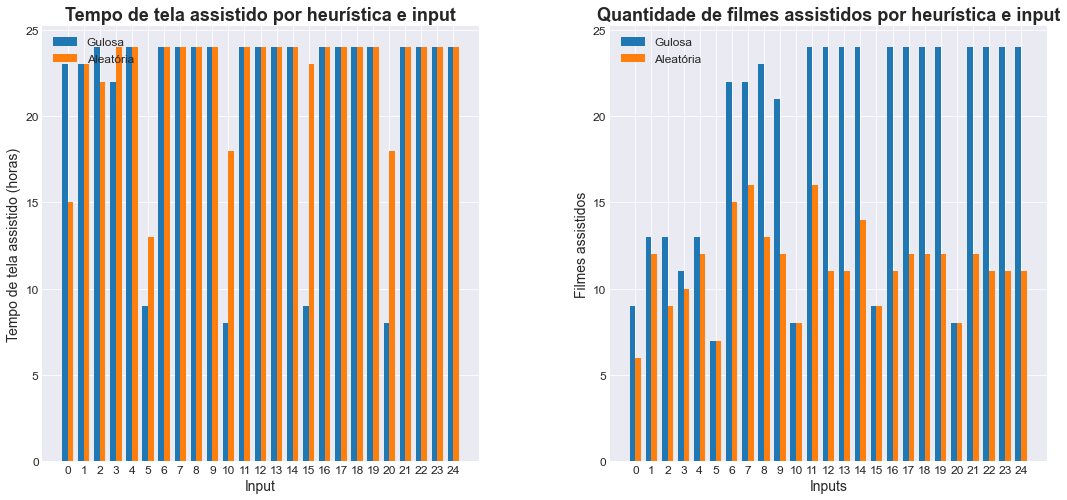

In [68]:
# Configurações do gráfico 1
bar_width = 0.35

# Dados das barras
gulosa_tela = np.array(gulosa_tempo_tela)
aleatoria_tela = np.array(aleatoria_tempo_tela)
ind = np.arange(len(total_filmes))

# Criar figura e eixos
fig, axs = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'wspace': 0.3})

# Gráfico 1 - Tempo de tela assistido
rects1 = axs[0].bar(ind, gulosa_tela, bar_width, label='Gulosa', color='C0')
rects2 = axs[0].bar(ind + bar_width, aleatoria_tela, bar_width, label='Aleatória', color='C1')

# Configurar eixos e legenda
axs[0].set_xlabel('Input', fontsize=14)
axs[0].set_ylabel('Tempo de tela assistido (horas)', fontsize=14)
axs[0].set_title('Tempo de tela assistido por heurística e input', fontsize=18, fontweight='bold')
axs[0].set_xticks(ind + bar_width / 2)
axs[0].set_xticklabels([f'{i}' for i in range(num_inputs)], fontsize=12)
axs[0].legend(fontsize=12)

# Configurações do gráfico 2
bar_width = 0.35
x_pos_gulosa = range(len(x_labels))
x_pos_aleatoria = [x + bar_width for x in x_pos_gulosa]

# Criar o gráfico de barras
rects3 = axs[1].bar(x_pos_gulosa, gulosa_data, width=bar_width, label="Gulosa", color='C0')
rects4 = axs[1].bar(x_pos_aleatoria, aleatoria_data, width=bar_width, label="Aleatória", color='C1')

# Definir o título e os rótulos dos eixos
axs[1].set_title("Quantidade de filmes assistidos por heurística e input", fontsize=18, fontweight='bold')
axs[1].set_xlabel("Inputs", fontsize=14)
axs[1].set_ylabel("Filmes assistidos", fontsize=14)

# Definir os ticks e os labels do eixo X
axs[1].set_xticks([x + bar_width / 2 for x in x_pos_gulosa])
axs[1].set_xticklabels(x_labels, fontsize=12)

# Adicionar a legenda
axs[1].legend(fontsize=12)

# Mostrar o gráfico
plt.show()


Vendo a comparação dos gráficos acima é possível tirar algumas conclusões. Primeiramente, se olhamos somente para o gráfico da direita e tiramos conclusões precipitadas, diríamos que a heurística gulosa é a melhor porque nela assistimos mais filmes. Mas quando comparamos ao gráfico da esquerda, vemos que isso na realidade é mentira! O gráfico da esquerda mostra que a heurística aleatória nos permite, mesmo com menos filmes, a ter mais tempo de tela justamente pelo fato dela ser aleatória, e não sempre estar buscando o filme que acaba e começa antes. Todavia, isso tem um custo... sabe qual?

##### Análise de Tempo

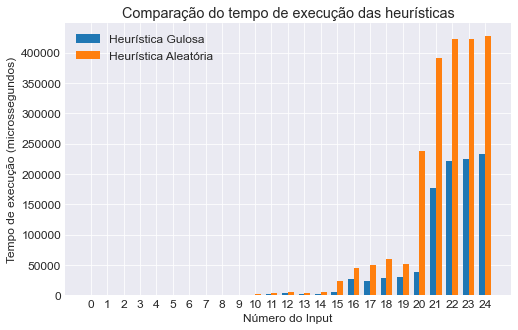

In [82]:
num_inputs = len(total_filmes)
bar_width = 0.35
x = np.arange(num_inputs)

fig, axs = plt.subplots(figsize=(8, 5))

axs.bar(x - bar_width/2, gulosa_tempos_execucao, bar_width, label="Heurística Gulosa")
axs.bar(x + bar_width/2, aleatoria_tempos_execucao, bar_width, label="Heurística Aleatória")

axs.set_xlabel("Número do Input")
axs.set_ylabel("Tempo de execução (microssegundos)")
axs.set_title("Comparação do tempo de execução das heurísticas")
axs.set_xticks(x)
axs.set_xticklabels([f"{i}" for i in range(num_inputs)])
axs.legend()

# Mostrar o gráfico
plt.show()


Aqui podemos analisar claramente que a heurística aleatória "passou um pouco do ponto" e demora substancialmente mais para executar do que a gulosa. Mas esse atraso também compensa na hora de analisarmos que de fato a aleatória é mais "potente" e consegue uma maior taxa de ocupação nas horas de tela do que a gulosa. Agora que já entendemos os prós e contras das duas heurísticas, e como elas refletiram no nosso contexto de estudo, por que não entender como as variáveis conversam entre elas?

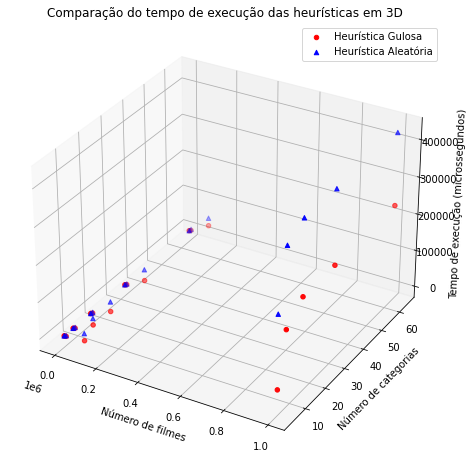

In [45]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Heurística Gulosa
ax.scatter(total_filmes, total_categorias, gulosa_tempos_execucao, c='r', marker='o', label='Heurística Gulosa')

# Heurística Aleatória
ax.scatter(total_filmes, total_categorias, aleatoria_tempos_execucao, c='b', marker='^', label='Heurística Aleatória')

ax.set_xlabel('Número de filmes')
ax.set_ylabel('Número de categorias')
ax.set_zlabel('Tempo de execução (microssegundos)')
ax.set_title('Comparação do tempo de execução das heurísticas em 3D')
ax.legend()

plt.show()

O gráfico acima retrata um resumo geral sobre as heurísticas. A gulosa se mostra mais rápida, mas isso não explica tudo. A aleatória por sua vez, se mostra muito mais lenta, crescendo consideravelmente mais no nível de tempo de execução quando comparado a heurística gulosa. Os gráficos abaixo ajudam a explicar melhor ainda o por quê disso.

<ipython-input-83-2c408cda8ed6>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1, projection='3d')
<ipython-input-83-2c408cda8ed6>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection='3d')


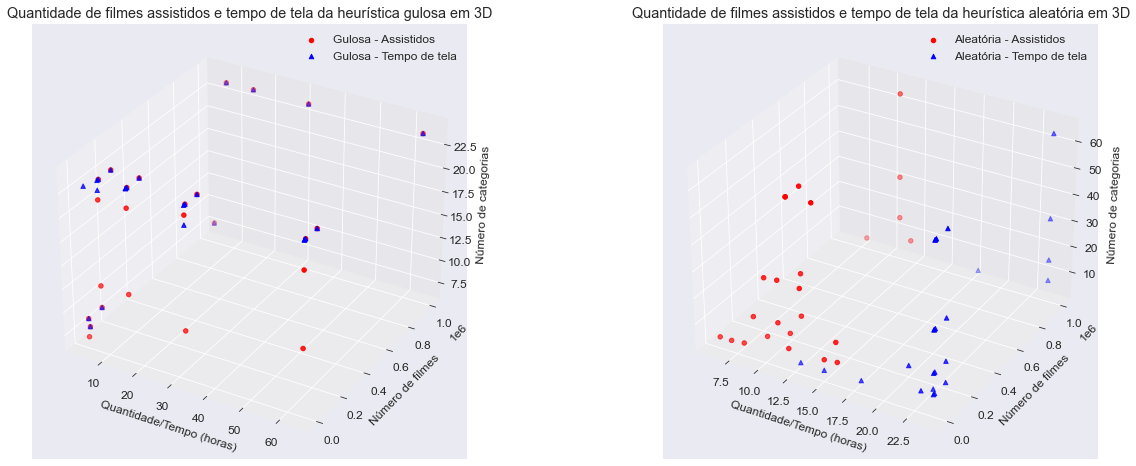

In [83]:
# Cria uma figura com duas colunas de subplots (1 linha, 2 colunas) e ajusta o espaço entre eles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plt.subplots_adjust(wspace=0.3)

# Heurística Gulosa
ax1 = plt.subplot(1, 2, 1, projection='3d')
ax1.scatter(total_categorias, total_filmes, gulosa_assistido, c='r', marker='o', label='Gulosa - Assistidos')
ax1.scatter(total_categorias, total_filmes, gulosa_tempo_tela, c='b', marker='^', label='Gulosa - Tempo de tela')
ax1.set_xlabel('Quantidade/Tempo (horas)')
ax1.set_ylabel('Número de filmes')
ax1.set_zlabel('Número de categorias')
ax1.set_title('Quantidade de filmes assistidos e tempo de tela da heurística gulosa em 3D')
ax1.legend()

# Heurística Aleatória
ax2 = plt.subplot(1, 2, 2, projection='3d')
ax2.scatter(aleatoria_assistido, total_filmes, total_categorias, c='r', marker='o', label='Aleatória - Assistidos')
ax2.scatter(aleatoria_tempo_tela, total_filmes, total_categorias, c='b', marker='^', label='Aleatória - Tempo de tela')
ax2.set_xlabel('Quantidade/Tempo (horas)')
ax2.set_ylabel('Número de filmes')
ax2.set_zlabel('Número de categorias')
ax2.set_title('Quantidade de filmes assistidos e tempo de tela da heurística aleatória em 3D')
ax2.legend()

plt.show()


Com o auxílio destes gráficos, podemos ver que existe uma correlação muito forte entre o número de filmes assistidos e o tempo de tela na heurística gulosa. Isso acontece pois o algoritmo dele é desenhado para justamente sempre pegar o filme que acaba e começa antes, assim somando as 24 horas de 1 em 1 hora, como é o caso de vários dos outputs que vimos. Já no caso da heurística aleatória, percebemos que não é bem assim que funciona. Neste caso, independente do número de filmes assistidos, a heurística tem um aproveitamento muito melhor de tempo de tela, se demonstrando melhor neste sentido. Porém, temos de ter em vista o fato de que a heurística aleatória tem um preço a se pagar, que já foi mostrado lá em cima; o **tempo de execução**!

## Conclusão

Com base nos resultados acima, a conclusão pode ser tirada da seguinte maneira:

- Tempo de execução: A heurística gulosa tem um tempo de execução consideravelmente menor que o da heurística aleatória. Isso se deve ao fato da heurística aleatória ter uma complexidade maior e lidar com aleatoriedade.

- Filmes assistidos: A quantidade de filmes assistidos pela heurística gulosa é consistentemente maior do que a heurística aleatória em todos os casos de teste. Isso indica que a heuristica tem uma capacidade maior de alocar filmes curtos devido a sua consistência. 

- Tempo na tela: A heurística aleatória consistentemente aparece como a melhor candidata neste quesito. Mesmo não tendo a maior quantidade de filmes assistidos, a aleatória possui uma maior capacidade de verificações e aleatoriedade.

Sendo assim, para este caso não existe uma heurística melhor do que a outra. Cada uma prioriza algo. Enquanto a aleatória consegue ter mais tempo de tela e ser eficiente neste quesito, a gulosa é muito mais rapida que a outra. Assim, tudo depende de uma perspectiva e de prioridades que o usuário ou quem for ter acesso a elas quer.